- BigGAN (actually not big here)
- hierachical latent codes
- not apply truncated trick
- ref: https://github.com/taki0112/BigGAN-Tensorflow/blob/master/BigGAN_128.py

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def UpResBlock(ch, ks, use_bias):
    def f(args):
        x_in, z = args
        
        x1 = BatchNormCond()([x_in, z]) 
        x1 = Activation('relu')(x1)
        x1 = Conv2DTranspose(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x1)
        
        x2 = BatchNormCond()([x1, z])
        x2 = Activation('relu')(x2)
        x2 = Conv2DTranspose(ch, kernel_size=ks, strides=1, use_bias=use_bias, padding='same')(x2)
        
        x_in = Conv2DTranspose(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x_in)
        
        return x_in + x2
    return f

def DownResBlock(ch, ks, use_bias):
    def f(x_in):
        x = BatchNormalization()(x_in)
        x = Activation('relu')(x)
        x = Conv2D(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(ch, kernel_size=ks, strides=1, use_bias=use_bias, padding='same')(x)

        x_in = Conv2D(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x_in)
        
        return x_in + x
    return f

def BatchNormCond():
    def f(args):
        x, z = args
        
        c = x.shape.as_list()[-1]
        decay = 0.9
        eps = 1e-5

        test_mean = tf.Variable(lambda : tf.zeros(c), trainable=False)
        test_var = tf.Variable(lambda : tf.ones(c), trainable=False)
        
        beta = Dense(c)(z)
        gamma = Dense(c)(z)

        beta = tf.reshape(beta, shape=[-1, 1, 1, c])
        gamma = tf.reshape(gamma, shape=[-1, 1, 1, c])
        
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
        ema_mean = test_mean.assign(test_mean*decay + batch_mean * (1  - decay))
        ema_var = test_var.assign(test_var*decay + batch_var * (1-decay))

        with tf.control_dependencies([ema_mean, ema_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, eps)
    return f

def hw_flatten(x):
    return tf.reshape(x, shape=[tf.shape(x)[0], tf.shape(x)[1]*tf.shape(x)[2], tf.shape(x)[-1]])

def Attention(ch):
    def f(x):
        gamma = tf.Variable(initial_value=0, trainable=True, dtype=tf.float32)

        f = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        g = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        h = Conv2D(ch, kernel_size=1, strides=1, padding='same')(x)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)

        beta = tf.nn.softmax(s)

        o = tf.matmul(beta, hw_flatten(h))
        o = tf.reshape(o, shape=tf.shape(x))
        x = gamma*o + x

        return x
    return f

In [4]:
class BigGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(BigGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(BigGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = (self.z_dim, ))
        splitted = tf.split(inputs, 3, axis=1)
        
        x = Dense(128*7*7, activation='relu')(splitted[0])
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        
        x = UpResBlock(64, 3, False)([x, splitted[1]]) # 14, 14, 64
        x = Attention(64)(x)
        
        x = UpResBlock(32, 3, False)([x, splitted[2]]) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = DownResBlock(16, 3, False)(inputs)
        x = Attention(16)(x)
        
        x = DownResBlock(32, 3, False)(x)
        
        x = DownResBlock(64, 3, False)(x)
        x = Activation('relu')(x)
        
        x = tf.reduce_sum(x, axis=[1, 2]) # global sum pooling
        outputs = Dense(1)(x)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 120))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
shape = train_X.shape[1:]
gan = BigGAN(shape, 120)

gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 40), (None,  0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         257152      tf_op_layer_split[0][0]          
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 128)    0           dense[0][0]                      
__________________________________________________________________________________________

In [8]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
469/469 [==============================] - ETA: 0s - d_loss: 0.3210 - g_loss: 2.1379

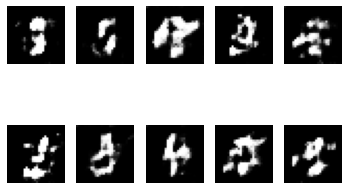

469/469 [==============================] - 24s 51ms/step - d_loss: 0.3210 - g_loss: 2.1373
Epoch 2/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3375 - g_loss: 2.0339
Epoch 3/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3069 - g_loss: 2.2203
Epoch 4/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3576 - g_loss: 1.8974
Epoch 5/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3877 - g_loss: 1.7522
Epoch 6/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4127 - g_loss: 1.6084
Epoch 7/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4227 - g_loss: 1.5906
Epoch 8/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4381 - g_loss: 1.5224
Epoch 9/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4314 - g_loss: 1.5316
Epoch 10/101
469/469 [==============================] - 23s 50ms/step - d_loss: 0.415

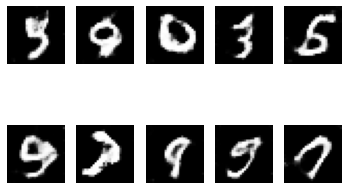

469/469 [==============================] - 23s 50ms/step - d_loss: 0.4090 - g_loss: 1.6304
Epoch 12/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3930 - g_loss: 1.7197
Epoch 13/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3727 - g_loss: 1.7948
Epoch 14/101
469/469 [==============================] - 24s 50ms/step - d_loss: 0.3629 - g_loss: 1.8735
Epoch 15/101
469/469 [==============================] - 24s 50ms/step - d_loss: 0.3485 - g_loss: 1.9688
Epoch 16/101
469/469 [==============================] - 23s 50ms/step - d_loss: 0.3364 - g_loss: 2.0366
Epoch 17/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3254 - g_loss: 2.0945
Epoch 18/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3152 - g_loss: 2.1577
Epoch 19/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3002 - g_loss: 2.2357
Epoch 20/101
469/469 [==============================] - 23s 49ms/step - d_los

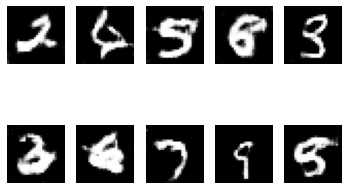

469/469 [==============================] - 23s 50ms/step - d_loss: 0.2845 - g_loss: 2.3562
Epoch 22/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2781 - g_loss: 2.4075
Epoch 23/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2669 - g_loss: 2.4688
Epoch 24/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2611 - g_loss: 2.5343
Epoch 25/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2599 - g_loss: 2.5624
Epoch 26/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2501 - g_loss: 2.6162
Epoch 27/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2445 - g_loss: 2.6769
Epoch 28/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2408 - g_loss: 2.7148
Epoch 29/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2346 - g_loss: 2.7402
Epoch 30/101
469/469 [==============================] - 23s 49ms/step - d_los

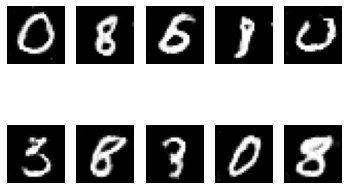

469/469 [==============================] - 23s 50ms/step - d_loss: 0.2293 - g_loss: 2.8250
Epoch 32/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2251 - g_loss: 2.8464
Epoch 33/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2230 - g_loss: 2.8959
Epoch 34/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2157 - g_loss: 2.9185
Epoch 35/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2145 - g_loss: 2.9405
Epoch 36/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2142 - g_loss: 2.9880
Epoch 37/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2081 - g_loss: 3.0044
Epoch 38/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2079 - g_loss: 3.0581
Epoch 39/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2020 - g_loss: 3.0529
Epoch 40/101
469/469 [==============================] - 23s 49ms/step - d_los

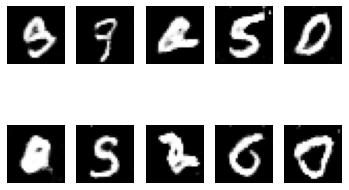

469/469 [==============================] - 23s 49ms/step - d_loss: 0.2042 - g_loss: 3.0723
Epoch 42/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2000 - g_loss: 3.0907
Epoch 43/101
469/469 [==============================] - 23s 50ms/step - d_loss: 0.2023 - g_loss: 3.0813
Epoch 44/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2032 - g_loss: 3.0698
Epoch 45/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2030 - g_loss: 3.0686
Epoch 46/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2141 - g_loss: 3.0165
Epoch 47/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2116 - g_loss: 2.9866
Epoch 48/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2283 - g_loss: 2.9080
Epoch 49/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.2336 - g_loss: 2.8124
Epoch 50/101
469/469 [==============================] - 23s 49ms/step - d_los

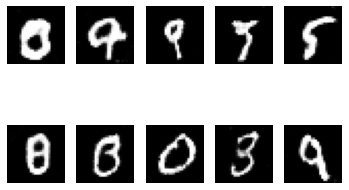

469/469 [==============================] - 23s 50ms/step - d_loss: 0.2720 - g_loss: 2.5697
Epoch 52/101
469/469 [==============================] - 24s 50ms/step - d_loss: 0.2879 - g_loss: 2.4371
Epoch 53/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3022 - g_loss: 2.3487
Epoch 54/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3201 - g_loss: 2.2361
Epoch 55/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3301 - g_loss: 2.1663
Epoch 56/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3427 - g_loss: 2.0886
Epoch 57/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3549 - g_loss: 2.0412
Epoch 58/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3656 - g_loss: 1.9732
Epoch 59/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.3775 - g_loss: 1.8918
Epoch 60/101
469/469 [==============================] - 23s 49ms/step - d_los

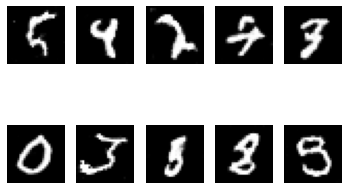

469/469 [==============================] - 23s 49ms/step - d_loss: 0.4109 - g_loss: 1.7351
Epoch 62/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4250 - g_loss: 1.6707
Epoch 63/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4392 - g_loss: 1.6141
Epoch 64/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4568 - g_loss: 1.5425
Epoch 65/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4657 - g_loss: 1.5032
Epoch 66/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4702 - g_loss: 1.4827
Epoch 67/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4764 - g_loss: 1.4603
Epoch 68/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4783 - g_loss: 1.4541
Epoch 69/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4800 - g_loss: 1.4456
Epoch 70/101
469/469 [==============================] - 23s 49ms/step - d_los

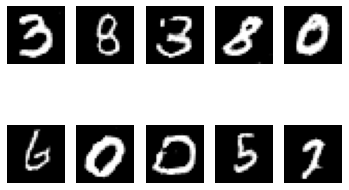

469/469 [==============================] - 23s 49ms/step - d_loss: 0.4808 - g_loss: 1.4348
Epoch 72/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4848 - g_loss: 1.4243
Epoch 73/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4882 - g_loss: 1.4179
Epoch 74/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4897 - g_loss: 1.4075
Epoch 75/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4887 - g_loss: 1.4092
Epoch 76/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4911 - g_loss: 1.4003
Epoch 77/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4909 - g_loss: 1.3974
Epoch 78/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4950 - g_loss: 1.3918
Epoch 79/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4978 - g_loss: 1.3788
Epoch 80/101
469/469 [==============================] - 23s 49ms/step - d_los

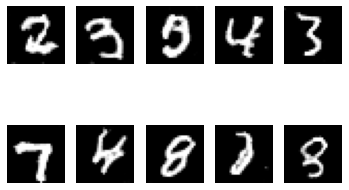

469/469 [==============================] - 23s 50ms/step - d_loss: 0.4981 - g_loss: 1.3723
Epoch 82/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4958 - g_loss: 1.3767
Epoch 83/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4956 - g_loss: 1.3790
Epoch 84/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4965 - g_loss: 1.3781
Epoch 85/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4955 - g_loss: 1.3733
Epoch 86/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4980 - g_loss: 1.3723
Epoch 87/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.5005 - g_loss: 1.3605
Epoch 88/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4991 - g_loss: 1.3661
Epoch 89/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4983 - g_loss: 1.3672
Epoch 90/101
469/469 [==============================] - 23s 49ms/step - d_los

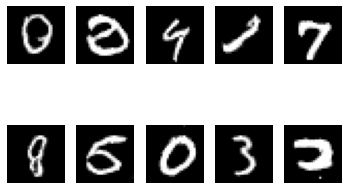

469/469 [==============================] - 23s 50ms/step - d_loss: 0.4970 - g_loss: 1.3703
Epoch 92/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4971 - g_loss: 1.3675
Epoch 93/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4980 - g_loss: 1.3714
Epoch 94/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4982 - g_loss: 1.3750
Epoch 95/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4983 - g_loss: 1.3669
Epoch 96/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4972 - g_loss: 1.3722
Epoch 97/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4954 - g_loss: 1.3754
Epoch 98/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4959 - g_loss: 1.3794
Epoch 99/101
469/469 [==============================] - 23s 49ms/step - d_loss: 0.4970 - g_loss: 1.3772
Epoch 100/101
469/469 [==============================] - 23s 49ms/step - d_lo

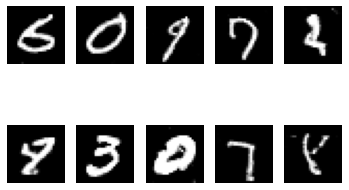

469/469 [==============================] - 23s 50ms/step - d_loss: 0.4967 - g_loss: 1.3824


In [9]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=128)